# Modifying the `Schedule` object

GeNet has a number of methods to change the Schedule objects. Make sure you validate the end result.

In [1]:
# read example network
import pandas as pd
from genet import Network, Stop, Route, Service, read_matsim
import os
from pprint import pprint

path_to_matsim_network = '../example_data/pt2matsim_network'

network = os.path.join(path_to_matsim_network, 'network.xml')
schedule = os.path.join(path_to_matsim_network, 'schedule.xml')
vehicles = os.path.join(path_to_matsim_network, 'vehicles.xml')
n = read_matsim(
    path_to_network=network, 
    epsg='epsg:27700', 
    path_to_schedule=schedule, 
    path_to_vehicles=vehicles
)
# you don't need to read the vehicles file, but doing so ensures all vehicles
# in the schedule are of the expected type and the definition of the vehicle
# is preserved
n.print()

Graph info: Name: Network graph
Type: MultiDiGraph
Number of nodes: 1662
Number of edges: 3166
Average in degree:   1.9049
Average out degree:   1.9049 
Schedule info: Schedule:
Number of services: 9
Number of routes: 68
Number of stops: 118


## Adding Routes, Services

You can add `Route`s and `Service`s. To add a `Route`, you need to identify which existing `Service` it should come under.

You can make Routes by specifying a headway parameter, that will generate explicit trips for you:

In [2]:
route = Route(
    route_short_name='N55',
    mode='bus',
    headway_spec={('07:00:00','08:00:00'): 15},
    arrival_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
    departure_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
    id='new_route',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
    await_departure= [True, True, True, True],
    stops=[n.schedule.stop('490000235X'),
          Stop(id='new_stop', x=529500, y=181300,
            name='New Stop', epsg='epsg:27700'),
          Stop(id='other_new_stop', x=529502, y=181302,
            name='Other New Stop', epsg='epsg:27700'),
          n.schedule.stop('490010689KB')]
)

In [3]:
route.trips

{'trip_id': ['new_route_07:00:00',
  'new_route_07:15:00',
  'new_route_07:30:00',
  'new_route_07:45:00',
  'new_route_08:00:00'],
 'trip_departure_time': ['07:00:00',
  '07:15:00',
  '07:30:00',
  '07:45:00',
  '08:00:00'],
 'vehicle_id': ['veh_bus_new_route_07:00:00',
  'veh_bus_new_route_07:15:00',
  'veh_bus_new_route_07:30:00',
  'veh_bus_new_route_07:45:00',
  'veh_bus_new_route_08:00:00']}

Or you can use provide the exact trips and vehicles on this route:

In [4]:
route = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['fun_trip_1', 'fun_trip_2'], 
           'trip_departure_time': ['03:53:00', '16:23:00'], 
           'vehicle_id': ['fun_bus_1', 'fun_bus_2']},
    arrival_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
    departure_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
    id='new_route',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
    await_departure= [True, True, True, True],
    stops=[n.schedule.stop('490000235X'),
          Stop(id='new_stop', x=529500, y=181300,
            name='New Stop', epsg='epsg:27700'),
          Stop(id='other_new_stop', x=529502, y=181302,
            name='Other New Stop', epsg='epsg:27700'),
          n.schedule.stop('490010689KB')]
)

You can create and add a new `Service`, or add the route to an existing Service

In [5]:
new_service = Service(id='new_service', routes=[route])
new_service.print()

Service ID: new_service
Name: N55
Number of routes: 1
Number of stops: 4


In [6]:
n.schedule.add_service(Service(id='new_service', routes=[route]))

2021-12-13 13:12:00,938 - Added Service with index `new_service`, data={'id': 'new_service', 'name': 'N55'} and Routes: ['new_route']


<Service instance at 4994797840: with 1 routes>

In [7]:
n.schedule.add_route('20274', route)

2021-12-13 13:12:01,340 - Route with ID `new_route` within already exists in the Schedule. This Route will be reindexed to `20274_4`
2021-12-13 13:12:01,346 - Reindexed Route from new_route to 20274_4
2021-12-13 13:12:01,365 - Added Route with index `20274_4`, data={'route_short_name': 'N55', 'mode': 'bus', 'arrival_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'route_long_name': '', 'id': '20274_4', 'trips': {'trip_id': ['fun_trip_1', 'fun_trip_2'], 'trip_departure_time': ['03:53:00', '16:23:00'], 'vehicle_id': ['fun_bus_1', 'fun_bus_2']}, 'route': [], 'await_departure': [True, True, True, True], 'ordered_stops': ['490000235X', 'new_stop', 'other_new_stop', '490010689KB']} to Service `20274` within the Schedule
/Users/kasia.kozlowska/PycharmProjects/ABM/genet/genet/schedule_elements.py:1366: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  self.vehicles = {**df.T.to_dict(

<Route instance at 4994815056: with 4 stops and 2 trips>

In [8]:
n.schedule['new_service'].print()

Service ID: new_service
Name: N55
Number of routes: 1
Number of stops: 4


In [9]:
n.schedule.route('20274_4').ordered_stops

['490000235X', 'new_stop', 'other_new_stop', '490010689KB']

You can also refer to existing stops in the `Schedule` when creating a`Route` to be added. You can either just pass Stop IDs as strings or use a stop method on the schedule to take and use that stop object. Note that in the case of the former (passing ID strings), the route will not have the spatial information for those stops until it is added to the Schedule.

In [10]:
r = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['some_trip_1'], 
           'trip_departure_time': ['16:23:00'], 
           'vehicle_id': ['some_bus_2']},
   arrival_offsets=['00:00:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:06:00'],
   id='another_new_route',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True],
   stops=['490000235X.link:834', 
          '490010689KB.link:981']
)

In [11]:
r.graph().nodes['490000235X.link:834']

{'routes': {'another_new_route'}}

In [12]:
n.schedule.add_route('20274', r)

2021-12-13 13:12:01,800 - Added Route with index `another_new_route`, data={'route_short_name': 'N55', 'mode': 'bus', 'arrival_offsets': ['00:00:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route', 'trips': {'trip_id': ['some_trip_1'], 'trip_departure_time': ['16:23:00'], 'vehicle_id': ['some_bus_2']}, 'route': [], 'await_departure': [True, True], 'ordered_stops': ['490000235X.link:834', '490010689KB.link:981']} to Service `20274` within the Schedule


<Route instance at 4998108752: with 2 stops and 1 trips>

In [13]:
r.graph().nodes['490000235X.link:834']

{'services': {'14134', '18853', '20274'},
 'routes': {'VJ12ba6089dfb2733e29c415a1a0015fef30fd5305',
  'VJ256e98df611ff48afe737ddc81cbcde82e4e81c8',
  'VJ2aba67e3ed98f2ed5f5966c1ac394cbf6d1943d7',
  'VJ375a660d47a2aa570aa20a8568012da8497ffecf',
  'VJ4e2b897edf0e7b8a8e3b5516ab43ce56f72c5cff',
  'VJa7f37392e276aeac26c7e73bbc05e6a71af38dba',
  'VJd78967364a302cf232c5139d40622dcb6c238c9e',
  'VJdf3936da1a51eb33db594ef99738802c14b19995',
  'VJf3e316e5e605bb512147dee2a989be5a82ef1b5f',
  'VJf9a22035ae6f25bb420df833474943ad76065c89',
  'another_new_route'},
 'id': '490000235X.link:834',
 'x': 529981.7958802709,
 'y': 181412.0975758662,
 'epsg': 'epsg:27700',
 'name': 'Tottenham Court Road Station (Stop X)',
 'lon': -0.12809598708996447,
 'lat': 51.51668503324075,
 's2_id': 5221390722025467597,
 'linkRefId': '834',
 'isBlocking': 'false'}

In [14]:
r = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['some_trip_1'], 
           'trip_departure_time': ['16:23:00'], 
           'vehicle_id': ['some_bus_2']},
   arrival_offsets=['00:00:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:06:00'],
   id='another_new_route_2',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True],
   stops=[n.schedule.stop('490000235X.link:834'), 
          n.schedule.stop('490010689KB.link:981')]
)
n.schedule.add_route('20274', r)

2021-12-13 13:12:02,089 - Added Route with index `another_new_route_2`, data={'route_short_name': 'N55', 'mode': 'bus', 'arrival_offsets': ['00:00:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_2', 'trips': {'trip_id': ['some_trip_1'], 'trip_departure_time': ['16:23:00'], 'vehicle_id': ['some_bus_2']}, 'route': [], 'await_departure': [True, True], 'ordered_stops': ['490000235X.link:834', '490010689KB.link:981']} to Service `20274` within the Schedule


<Route instance at 4999504016: with 2 stops and 1 trips>

Note that for a Schedule to be a valid MATSim network, each stop referred to by a route needs a `linkRefId` attribute which links the stop to the `Network`.

Trying to add Stops with IDs already in the Schedule will result in an error, unless the `force=True` is set. The added route/service will inherit the data stored under those stops. The idea is that you can either specify the Stops in the route/service to be added correctly, or if they are to be changed, you use a dedicated method - check section 'Modifying data' below.

In [15]:
route = Route(
    route_short_name='N55',
    mode='bus',
    trips={'trip_id': ['fun_trip_1', 'fun_trip_2'], 
           'trip_departure_time': ['03:53:00', '16:23:00'], 
           'vehicle_id': ['fun_bus_1', 'fun_bus_2']},
   arrival_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
   departure_offsets=['00:00:00', '00:02:00', '00:04:00', '00:06:00'],
   id='another_new_route_3',
#    route= ['834', '1573', '3139', '3141', '574', '3154', '979', '980', '981'],
   await_departure= [True, True, True, True],
   stops=[
       Stop(id='490000235X.link:834', x=529981, y=181412, epsg='epsg:27700'),
       Stop(id='new_stop', x=529500, y=181300, epsg='epsg:27700', name='New Stop'),
       Stop(id='other_new_stop', x=529502, y=181302, epsg='epsg:27700', name='Other New Stop'),
       Stop(id='490010689KB.link:981', x=529166, y=181256, epsg='epsg:27700')
   ]
)

n.schedule.add_route('20274', route, force=True)

2021-12-13 13:12:04,245 - The following stops will inherit the data currently stored under those Stop IDs in the Schedule: ['490000235X.link:834', '490010689KB.link:981'].
2021-12-13 13:12:04,251 - Added Route with index `another_new_route_3`, data={'route_short_name': 'N55', 'mode': 'bus', 'arrival_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_3', 'trips': {'trip_id': ['fun_trip_1', 'fun_trip_2'], 'trip_departure_time': ['03:53:00', '16:23:00'], 'vehicle_id': ['fun_bus_1', 'fun_bus_2']}, 'route': [], 'await_departure': [True, True, True, True], 'ordered_stops': ['490000235X.link:834', 'new_stop', 'other_new_stop', '490010689KB.link:981']} to Service `20274` within the Schedule


<Route instance at 5002331728: with 4 stops and 2 trips>

Note the message above: `The following stops will inherit the data currently stored under those Stop IDs in the Schedule: ['490000235X.link:834', '490010689KB.link:981'].`

NOTE: adding routes and services results in new vehicles (unless you reuse the ones already in the Schedule---beware that the same vehicle cannot service multiple trips at the same time, genet does not currently have checks for this, the user needs to be mindful of the physics of shared vehicles). New vehicles need definitions, you can add them yourself to `schedule.vehicles['vehicle_id'] = {'type': 'bus'}` ensuring this vehicle type is defined in `schedule.vehicle_types['bus']`, or you can use a genet method to generate those vehicles, the type will be derived from the mode of the route. Then you can check if all of the types that vehicles are referring to have definitions.

In [16]:
len(n.schedule.vehicles)

13293

In [17]:
n.schedule.generate_vehicles()

In [18]:
n.schedule.validate_vehicle_definitions()

2021-12-13 13:12:05,117 - The following vehicle types are missing from the `vehicle_types`  attribute: {'bus'}
2021-12-13 13:12:05,118 - Vehicles affected by missing vehicle types: {'fun_bus_1': {'type': 'bus'}, 'fun_bus_2': {'type': 'bus'}, 'some_bus_2': {'type': 'bus'}}


False

In [19]:
len(n.schedule.vehicles)

13293

In [20]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
0,2021-12-13 13:12:00,add,service,None,new_service,None,"{'id': 'new_service', 'name': 'N55'}","[(add, , [('id', 'new_service'), ('name', 'N55..."
1,2021-12-13 13:12:01,add,route,None,20274_4,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, , [('route_short_name', 'N55'), ('mode'..."
2,2021-12-13 13:12:01,add,route,None,another_new_route,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, , [('route_short_name', 'N55'), ('mode'..."
3,2021-12-13 13:12:02,add,route,None,another_new_route_2,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, , [('route_short_name', 'N55'), ('mode'..."
4,2021-12-13 13:12:04,add,route,None,another_new_route_3,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, , [('route_short_name', 'N55'), ('mode'..."


There are no methods to add `Stop` objects on their own. They are added to the Schedule with `Route` and `Service` objects.

### Routing added Services/Routes

You can use methods in GeNet to relate the Stops of PT services and find network routes between them. First you need to know the ID of the Service you want to snap (you can also snap the entire schedule, but depending on the size and complexity of your network and schedule it might take a long time). GeNet will then relate all stops in that service to a link in the Network graph and route all of the `Route`s of the `Service` object. It will do this for directed subsets (subgraphs) of the Service (e.g. if you have a Northbound and Southboud service, the stops may have to find different links in the graph)

There are a lot of different parameters you can add to this method, that give you a bit more control. 
- `solver`: You can specify different mathematical solvers. For example GLPK, an open source solver which can be found here: https://www.gnu.org/software/glpk/. Another good open source choice is CBC: https://projects.coin-or.org/Cbc. You specify it as a string e.g. 'glpk', 'cbc', 'gurobi'. The solver needs to support MILP - mixed integer linear programming
- `allow_partial`: Sometimes there isn't a link available for snapping within threshold for all stops. If allowed (default) an artificial self-loop link will be created as well as any connecting links to that unsnapped stop, under modal conditions. If set to False and the problem is partial, it will raise PartialMaxStableSetProblem error instead.
- `distance_threshold`, `step_size`: You can vary the threshold for snapping stops to links. There are two parameters, the overall threshold and a step size; when snapping, the search area for links increases in steps until some links are found, we don't use the threshold right away because we don't want to have too many choices for snapping (makes it a little less heavy computationally)).
- `additional_modes`: You can specify additional modes (when snapping, genet will consider a modal subset of the network that matches the pt service, e.g. bus, but you might want to use links that allow cars too).
- `allow_directional_split`: You can opt for splitting the problem of snapping by direction. GeNet will then solve a series of problems for subgraphs (disjoint w.r.t. edges) of the Service. This is useful for rail type services that might share the same stop regardless of direction (in comparison to buses which have distinct bus stops, depending on which way they're travelling).

Check the methods' doc strings for up to date details.

In [21]:
n.schedule['new_service'].route('new_route').route

[]

In [22]:
n.schedule['new_service'].route('new_route').ordered_stops

['490000235X', 'new_stop', 'other_new_stop', '490010689KB']

In [23]:
n.route_service('new_service')

2021-12-13 13:12:07,535 - Routing Service new_service with modes = {'bus'}
2021-12-13 13:12:07,598 - Building Maximum Stable Set for PT graph with 4 stops and 3 edges
2021-12-13 13:12:09,206 - This Maximum Stable Set Problem is partially viable.
2021-12-13 13:12:09,207 - Maximum Stable Set problem to snap the PT graph to the network is partially viable, meaning not all stops have found a link to snap to within the distance_threshold.Partial snapping is ON, this problem will proceed to the solver.
2021-12-13 13:12:09,207 - Passing problem to solver
2021-12-13 13:12:09,209 - Initializing ordered Set vertices with a fundamentally unordered data source (type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
2021-12-13 13:12:09,242 - Passing problem to solver
2021-12-13 13:12:09,629 - Successfully snapped 3 stops to network links.
2021-12-13 13:12:09,685 - Stop ID changes detected for Routes: {'new_route'}
2021-12-13 13:12:09,688 - Changed Route attributes for 1 route

In [24]:
n.schedule['new_service'].route('new_route').route

['artificial_link===from:490000235X===to:490000235X',
 'artificial_link===from:490000235X===to:9521035',
 '3154',
 '979',
 '980',
 '981']

In [25]:
n.schedule['new_service'].route('new_route').ordered_stops

['490000235X.link:artificial_link===from:490000235X===to:490000235X',
 'new_stop.link:3154',
 'other_new_stop.link:3154',
 '490010689KB.link:981']

## Reindexing

In [26]:
n.schedule['new_service'].reindex(new_id='more_appropriate_id')

2021-12-13 13:12:09,936 - Reindexed Service from new_service to more_appropriate_id


In [27]:
n.schedule.route('new_route').reindex(new_id='more_appropriate_route_id')

2021-12-13 13:12:09,965 - Reindexed Route from new_route to more_appropriate_route_id


In [28]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
3,2021-12-13 13:12:02,add,route,None,another_new_route_2,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, , [('route_short_name', 'N55'), ('mode'..."
4,2021-12-13 13:12:04,add,route,None,another_new_route_3,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, , [('route_short_name', 'N55'), ('mode'..."
5,2021-12-13 13:12:09,modify,route,new_route,new_route,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","{'route_short_name': 'N55', 'mode': 'bus', 'ar...","[(add, route, [(0, 'artificial_link===from:490..."
6,2021-12-13 13:12:09,modify,service,new_service,more_appropriate_id,{'id': 'new_service'},{'id': 'more_appropriate_id'},"[(change, id, (new_service, more_appropriate_i..."
7,2021-12-13 13:12:09,modify,route,new_route,more_appropriate_route_id,{'id': 'new_route'},{'id': 'more_appropriate_route_id'},"[(change, id, (new_route, more_appropriate_rou..."


## Removing Stops, Routes, Services

In [29]:
n.schedule.remove_service('more_appropriate_id')

/Users/kasia.kozlowska/PycharmProjects/ABM/genet/genet/schedule_elements.py:1366: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  self.vehicles = {**df.T.to_dict(), **self.vehicles}
2021-12-13 13:12:10,359 - Removed Service with index `more_appropriate_id`, data={'id': 'more_appropriate_id', 'name': 'N55'} and Routes: {'more_appropriate_route_id'}


In [30]:
for route_id in {'another_new_route', 'another_new_route_2', 'another_new_route_3'}:
    n.schedule.remove_route(route_id)

2021-12-13 13:12:10,611 - Removed Route with index `another_new_route_3`, data={'route_short_name': 'N55', 'mode': 'bus', 'arrival_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:02:00', '00:04:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_3', 'trips': {'trip_id': ['fun_trip_1', 'fun_trip_2'], 'trip_departure_time': ['03:53:00', '16:23:00'], 'vehicle_id': ['fun_bus_1', 'fun_bus_2']}, 'route': [], 'await_departure': [True, True, True, True], 'ordered_stops': ['490000235X.link:834', 'new_stop', 'other_new_stop', '490010689KB.link:981']}. It was linked to Service `20274`.
2021-12-13 13:12:10,875 - Removed Route with index `another_new_route_2`, data={'route_short_name': 'N55', 'mode': 'bus', 'arrival_offsets': ['00:00:00', '00:06:00'], 'departure_offsets': ['00:00:00', '00:06:00'], 'route_long_name': '', 'id': 'another_new_route_2', 'trips': {'trip_id': ['some_trip_1'], 'trip_departure_time': ['16:23:00'], 'vehicle_id':

In [31]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
7,2021-12-13 13:12:09,modify,route,new_route,more_appropriate_route_id,{'id': 'new_route'},{'id': 'more_appropriate_route_id'},"[(change, id, (new_route, more_appropriate_rou..."
8,2021-12-13 13:12:10,remove,service,more_appropriate_id,None,"{'id': 'more_appropriate_id', 'name': 'N55'}",None,"[(remove, , [('id', 'more_appropriate_id'), ('..."
9,2021-12-13 13:12:10,remove,route,another_new_route_3,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...",None,"[(remove, , [('route_short_name', 'N55'), ('mo..."
10,2021-12-13 13:12:10,remove,route,another_new_route_2,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...",None,"[(remove, , [('route_short_name', 'N55'), ('mo..."
11,2021-12-13 13:12:10,remove,route,another_new_route,None,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...",None,"[(remove, , [('route_short_name', 'N55'), ('mo..."


You can also remove `Stop`s. This will disconnect `Route`s and `Service`s using that `Stop`s and likely render them invalid. The method will warn you which `Route`s and `Servce`s are affected.

In [32]:
n.schedule.remove_stop('new_stop')

2021-12-13 13:12:11,261 - Removed Stops with indices `['new_stop']`.Routes affected: {'20274_4'}. Services affected: {'20274'}.


You can also remove `Stop`s. This will disconnect `Route`s and `Service`s using that `Stop`s and likely render them invalid. The method will warn you which `Route`s and `Servce`s are affected.

In [33]:
n.schedule.remove_unsused_stops()

2021-12-13 13:12:11,278 - Removed Stops with indices `['9400ZZLUESQ2', '9400ZZLUWRR4', '9400ZZLUOXC4', '9400ZZLUWRR1', '490000091F', '490000091E', '9400ZZLUOXC1', 'other_new_stop.link:3154', '9400ZZLUTCR4', '490010198W', '490015196R', '9400ZZLUGPS2', '490000235N', '9400ZZLUTCR3', '9400ZZLUOXC2', '490000173RD', '490000235W1', 'new_stop.link:3154', '490015196N', '490000252S', '9400ZZLUOXC3', '9400ZZLUWRR2', '490011126K', '490000252R', '9400ZZLURGP1', '9400ZZLURGP2', '9400ZZLUGDG1', '9400ZZLUOXC5', '490000356NE', '9400ZZLUESQ1', '9400ZZLUTCR1', '9400ZZLUWRR3', '490000235X.link:artificial_link===from:490000235X===to:490000235X', '9400ZZLUOXC6', '490013600C', '490000173RF', '490019675D']`.Routes affected: set(). Services affected: set().
2021-12-13 13:12:11,280 - Removed Stops with indecies `{'9400ZZLUESQ2', '9400ZZLUWRR4', '9400ZZLUOXC4', '9400ZZLUWRR1', '490000091F', '490000091E', '9400ZZLUOXC1', 'other_new_stop.link:3154', '9400ZZLUTCR4', '490010198W', '490015196R', '9400ZZLUGPS2', '4900

## Modifying data stored for Stops, Routes, Services

### Applying known or pre-computed changes
Applying changes or new attributes to Services, Routes and Stops can be done via Schedule level methods. They all work with a dictionary where the keys are the object IDs and the values are dictionaries holding attribute names and values. The method to extract a DataFrame on attributes comes in handy here. E.g.

In [34]:
df = n.schedule.service_attribute_data(keys='name')
df.head()

,name
15660,113
18853,N8
20274,N55
17732,N20
18915,N5


DataFrames are easy to work with. Youcould for exmaple manipulate the names or use other data to change these. For demonstration here, let's just set the names to something easy.

In [35]:
df['name'] = df['name'].apply(lambda x: f'Service_{x}')
df.head()

,name
15660,Service_113
18853,Service_N8
20274,Service_N55
17732,Service_N20
18915,Service_N5


You can then convert this to a dictionary and pass it to the `apply_attributes_to_services` method.

In [36]:
n.schedule.apply_attributes_to_services(df.T.to_dict())

2021-12-13 13:12:11,333 - Changed Service attributes for 9 services


In [37]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
16,2021-12-13 13:12:11,modify,service,18915,18915,"{'id': '18915', 'name': 'N5'}","{'id': '18915', 'name': 'Service_N5'}","[(change, name, (N5, Service_N5))]"
17,2021-12-13 13:12:11,modify,service,14134,14134,"{'id': '14134', 'name': '98'}","{'id': '14134', 'name': 'Service_98'}","[(change, name, (98, Service_98))]"
18,2021-12-13 13:12:11,modify,service,15234,15234,"{'id': '15234', 'name': '134'}","{'id': '15234', 'name': 'Service_134'}","[(change, name, (134, Service_134))]"
19,2021-12-13 13:12:11,modify,service,12430,12430,"{'id': '12430', 'name': '205'}","{'id': '12430', 'name': 'Service_205'}","[(change, name, (205, Service_205))]"
20,2021-12-13 13:12:11,modify,service,14073,14073,"{'id': '14073', 'name': '94'}","{'id': '14073', 'name': 'Service_94'}","[(change, name, (94, Service_94))]"


You can do the same for `Routes` and `Stops`. Your dictionaries cannot however hold changes to indices. You will encounter an error and should use `reindex` methods for such operations.

In [38]:
n.schedule.apply_attributes_to_routes(
    {'VJ375a660d47a2aa570aa20a8568012da8497ffecf': {
        'name': 'my_favourite_route', 
        'mode': 'piggyback'
    }}
)

2021-12-13 13:12:11,380 - Changed Route attributes for 1 routes


In [39]:
n.schedule.apply_attributes_to_stops(
    {'490000235YB.link:574': {'new_attribute': 'hello!'}}
)

2021-12-13 13:12:11,388 - Changed Stop attributes for 1 stops


In [40]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
18,2021-12-13 13:12:11,modify,service,15234,15234,"{'id': '15234', 'name': '134'}","{'id': '15234', 'name': 'Service_134'}","[(change, name, (134, Service_134))]"
19,2021-12-13 13:12:11,modify,service,12430,12430,"{'id': '12430', 'name': '205'}","{'id': '12430', 'name': 'Service_205'}","[(change, name, (205, Service_205))]"
20,2021-12-13 13:12:11,modify,service,14073,14073,"{'id': '14073', 'name': '94'}","{'id': '14073', 'name': 'Service_94'}","[(change, name, (94, Service_94))]"
21,2021-12-13 13:12:11,modify,route,VJ375a660d47a2aa570aa20a8568012da8497ffecf,VJ375a660d47a2aa570aa20a8568012da8497ffecf,"{'route_short_name': 'N55', 'mode': 'bus', 'ar...","{'route_short_name': 'N55', 'mode': 'piggyback...","[(change, mode, (bus, piggyback)), (add, , [('..."
22,2021-12-13 13:12:11,modify,stop,490000235YB.link:574,490000235YB.link:574,"{'services': {'20274', '14134', '18853'}, 'rou...","{'services': {'20274', '18853', '14134'}, 'rou...","[(add, , [('new_attribute', 'hello!')])]"


#### Trip and vehicle changes

You can use `trips_to_dataframe` to extract all of the trips, their departures and vehicle IDs associated with the trips in the schedule. Trip ids need not be unique, route IDs provide a secondary index. Associated service IDs are also given for convenience.

In [41]:
trips = n.schedule.trips_to_dataframe(gtfs_day='20210101')

In [42]:
trips.head()

,route_id,mode,service_id,trip_id,trip_departure_time,vehicle_id
0,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,VJ0380d3d1e03e99c0fbafe6fdd2f7b5c5766f018b_01:...,2021-01-01 01:30:00,veh_2241_bus
1,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,VJ210489c99419848f6b73db97b6ac3e1ad19ec817_01:...,2021-01-01 01:00:00,veh_2242_bus
2,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,VJ4dc979983ac1f0cbd7092f9ff8dbca0b9d2c6bcb_24:...,2021-01-02 00:30:00,veh_2243_bus
3,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531_02:...,2021-01-01 02:00:00,veh_2244_bus
4,VJ4e311a625836374adf4cfaa841224840dbeb7619,bus,14134,VJ01aabdea189073c29528b5ee10f9f297448ebd81_23:...,2021-01-01 23:22:00,veh_1130_bus


Let's change all of the trip ids to something shorter

In [43]:
trips['trip_id'] = 'trip_' + trips.index.to_series().astype(str)
trips.head()

,route_id,mode,service_id,trip_id,trip_departure_time,vehicle_id
0,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,trip_0,2021-01-01 01:30:00,veh_2241_bus
1,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,trip_1,2021-01-01 01:00:00,veh_2242_bus
2,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,trip_2,2021-01-02 00:30:00,veh_2243_bus
3,VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,bus,18915,trip_3,2021-01-01 02:00:00,veh_2244_bus
4,VJ4e311a625836374adf4cfaa841224840dbeb7619,bus,14134,trip_4,2021-01-01 23:22:00,veh_1130_bus


You can `set_trips_dataframe` which takes this dataframe and applies changes to all route trips based on the data in the dataframe. This means you can generate this DataFrame as shown below, manipulate trips (delete them, add new ones), change their departure times or change their vehicle ids to be shared for differnt trips, perhaps on some temporal logic and as long as the dataframe has the same schema, you can use it to set new trips in the schedule. This will appear in the changelog as a route level modify event.

Nb removing all trips of the same route from the dataframe will have no effect when being applied. If there is data in the dataframe for a route, all of its trips will be replaced by the data in the dataframe, and if there is no data for a route in the frame, no changes will be applied to that route (i.e. the trips attribute for routes missing from the dataframe will not be set as empty).

In [44]:
n.schedule.set_trips_dataframe(trips)
n.schedule.route_attribute_data(keys=[{'trips': 'trip_id'}]).head()

2021-12-13 13:12:11,598 - Changed Route attributes for 69 routes


,trips::trip_id
VJb08f8a2de01a4ef99d3b7fefd9022117ac307531,"[trip_0, trip_1, trip_2, trip_3]"
VJ4e311a625836374adf4cfaa841224840dbeb7619,"[trip_4, trip_5, trip_6, trip_7]"
VJb93a17a405fe502c5b3a2d6544105b0311da9fe2,"[trip_8, trip_9]"
20274_4,"[trip_10, trip_11]"
VJe18efadf172576fea7989ec1f233f26854c0f66a,"[trip_12, trip_13, trip_14, trip_15, trip_16, ..."


#### Generating new trips using headway information

You can replace old trips using headway information. This is useful when creating scenario networks. You can do it to a Route or Service (by specifying the route ID to be changed within) objects.

In [45]:
route_id = 'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13'

n.schedule.route(route_id).trips

{'trip_id': ['trip_210', 'trip_211'],
 'trip_departure_time': ['07:51:00', '22:50:00'],
 'vehicle_id': ['veh_887_bus', 'veh_888_bus']}

In [46]:
n.schedule.generate_trips_from_headway(
    route_id=route_id, headway_spec={('07:51:00', '22:50:00'): 120}) # headway in minutes

2021-12-13 13:12:11,635 - Changed Route attributes for 1 routes


In [47]:
n.schedule.route(route_id).trips

{'trip_id': ['VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_07:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_09:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_11:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_13:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_15:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_17:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_19:51:00',
  'VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_21:51:00'],
 'trip_departure_time': ['07:51:00',
  '09:51:00',
  '11:51:00',
  '13:51:00',
  '15:51:00',
  '17:51:00',
  '19:51:00',
  '21:51:00'],
 'vehicle_id': ['veh_Bus_VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_07:51:00',
  'veh_Bus_VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_09:51:00',
  'veh_Bus_VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_11:51:00',
  'veh_Bus_VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_13:51:00',
  'veh_Bus_VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_15:51:00',
  'veh_Bus_VJ6cf76a4c03cca468cb6954db7f7aad5ae189df13_17:

### Applying changes using functions or dictionary mappings

If you have some logic that can be written into a function of object's attributes, you can pass this to `apply_function_to_x` methods. You need to select `location`, which refers to the name of the attribute the result should be stored under. It can already exist and be overwritten. The function passed, is not expected to work with all objects. It will fail silently, only evaluating and generating outputs where possible.

In [48]:
from shapely.geometry import Point

def add_shapely_geometry_points(stop_attribs):
    return Point(stop_attribs['x'], stop_attribs['y'])

n.schedule.apply_function_to_stops(add_shapely_geometry_points, location='geometry')

2021-12-13 13:12:11,670 - Changed Stop attributes for 85 stops


In [49]:
n.schedule.change_log().tail(2)

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
176,2021-12-13 13:12:11,modify,stop,490000173RC,490000173RC,"{'id': '490000173RC', 'x': 529030.7471738418, ...","{'id': '490000173RC', 'x': 529030.7471738418, ...","[(add, , [('geometry', <shapely.geometry.point..."
177,2021-12-13 13:12:11,modify,stop,other_new_stop,other_new_stop,"{'services': {'20274'}, 'routes': {'20274_4'},...","{'services': {'20274'}, 'routes': {'20274_4'},...","[(add, , [('geometry', <shapely.geometry.point..."


In [50]:
n.schedule.stop_attribute_data(keys=['name', 'x', 'y', 'geometry']).head()

,name,x,y,geometry
490000235X.link:834,Tottenham Court Road Station (Stop X),529981.795880,181412.097576,POINT (529981.7958802709 181412.0975758662)
490000235YB.link:574,Oxford Street Soho Street (Stop YB),529570.781323,181336.281593,POINT (529570.7813227688 181336.2815925331)
490014214HE.link:3154,Wardour Street (Stop OM),529477.750156,181314.437043,POINT (529477.7501560802 181314.4370430721)
490010689KB.link:981,Great Titchfield Street Oxford Circus Station...,529166.734973,181256.336723,POINT (529166.7349732723 181256.3367228433)
490015196OG.link:2954,Holles Street (Stop OG),528823.776634,181291.362193,POINT (528823.776634044 181291.3621925522)


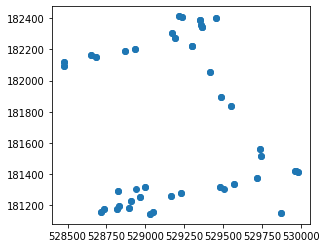

In [51]:
from geopandas import GeoDataFrame
GeoDataFrame(n.schedule.stop_attribute_data(keys='geometry')).plot()

In [52]:
n.schedule.stop('490000235YB.link:574').__dict__

{'id': '490000235YB.link:574',
 'x': 529570.7813227688,
 'y': 181336.2815925331,
 'epsg': 'epsg:27700',
 'name': 'Oxford Street  Soho Street (Stop YB)',
 'lat': 51.51609803324077,
 'lon': -0.13404398709291904,
 's2_id': 5221390696959560815,
 'linkRefId': '574',
 'isBlocking': 'false',
 'new_attribute': 'hello!',
 'geometry': <shapely.geometry.point.Point at 0x12a55e490>}

For this let's say we want to reduce the number of trips. For simplicity of demonstration we don't have about which trips we delete, but logic around timings of trips can be added in this function, as the trips are saved as one of routes attributes (check out the summary methods)

In [53]:
# before
len(n.schedule.route_trips_to_dataframe())

2021-12-13 13:12:12,004 - `route_trips_to_dataframe` method is deprecated and will be replaced by `trips_to_dataframe`in later versions.


1570

In [54]:
def reduce_trips(attribs):
    # just delete any other trip
    attribs['trips']['trip_id'] = attribs['trips']['trip_id'][::2]
    attribs['trips']['trip_departure_time'] = attribs['trips']['trip_departure_time'][::2]
    attribs['trips']['vehicle_id'] = attribs['trips']['vehicle_id'][::2]
    return attribs['trips']

n.schedule.apply_function_to_routes(reduce_trips, 'trips')

2021-12-13 13:12:12,085 - Changed Route attributes for 69 routes


In [55]:
# after
len(n.schedule.route_trips_to_dataframe())

2021-12-13 13:12:12,090 - `route_trips_to_dataframe` method is deprecated and will be replaced by `trips_to_dataframe`in later versions.


796

Note, this could also be done using the `route_trips_to_dataframe` and `set_route_trips_dataframe` mentioned above.

Let's give an example of using a mapping. We can re-use the service name DataFrame we generated above.

In [56]:
df['new_name'] = 'Brand_new_name' + df['name']
df.head()

,name,new_name
15660,Service_113,Brand_new_nameService_113
18853,Service_N8,Brand_new_nameService_N8
20274,Service_N55,Brand_new_nameService_N55
17732,Service_N20,Brand_new_nameService_N20
18915,Service_N5,Brand_new_nameService_N5


In [57]:
name_map = dict(zip(df['name'], df['new_name']))
name_map

{'Service_113': 'Brand_new_nameService_113',
 'Service_N8': 'Brand_new_nameService_N8',
 'Service_N55': 'Brand_new_nameService_N55',
 'Service_N20': 'Brand_new_nameService_N20',
 'Service_N5': 'Brand_new_nameService_N5',
 'Service_98': 'Brand_new_nameService_98',
 'Service_134': 'Brand_new_nameService_134',
 'Service_205': 'Brand_new_nameService_205',
 'Service_94': 'Brand_new_nameService_94'}

In this case, `location` refers to the attribute to be mapped.

In [58]:
n.schedule.apply_function_to_services(name_map, location='name')

2021-12-13 13:12:12,165 - Changed Service attributes for 9 services


In [59]:
n.schedule.change_log().tail()

,timestamp,change_event,object_type,old_id,new_id,old_attributes,new_attributes,diff
251,2021-12-13 13:12:12,modify,service,18915,18915,"{'id': '18915', 'name': 'Service_N5'}","{'id': '18915', 'name': 'Brand_new_nameService...","[(change, name, (Service_N5, Brand_new_nameSer..."
252,2021-12-13 13:12:12,modify,service,14134,14134,"{'id': '14134', 'name': 'Service_98'}","{'id': '14134', 'name': 'Brand_new_nameService...","[(change, name, (Service_98, Brand_new_nameSer..."
253,2021-12-13 13:12:12,modify,service,15234,15234,"{'id': '15234', 'name': 'Service_134'}","{'id': '15234', 'name': 'Brand_new_nameService...","[(change, name, (Service_134, Brand_new_nameSe..."
254,2021-12-13 13:12:12,modify,service,12430,12430,"{'id': '12430', 'name': 'Service_205'}","{'id': '12430', 'name': 'Brand_new_nameService...","[(change, name, (Service_205, Brand_new_nameSe..."
255,2021-12-13 13:12:12,modify,service,14073,14073,"{'id': '14073', 'name': 'Service_94'}","{'id': '14073', 'name': 'Brand_new_nameService...","[(change, name, (Service_94, Brand_new_nameSer..."


In [60]:
{s.name for s in n.schedule.services()}

{'Brand_new_nameService_113',
 'Brand_new_nameService_134',
 'Brand_new_nameService_205',
 'Brand_new_nameService_94',
 'Brand_new_nameService_98',
 'Brand_new_nameService_N20',
 'Brand_new_nameService_N5',
 'Brand_new_nameService_N55',
 'Brand_new_nameService_N8'}

## Subsetting

You can subset the Schedule object using Service IDs.

In [61]:
services = n.schedule.extract_service_ids_on_attributes(
    {'name': ['Brand_new_nameService_134', 'Brand_new_nameService_98']})
len(services)

2

In [62]:
n.schedule.print()

Schedule:
Number of services: 9
Number of routes: 69
Number of stops: 85


In [63]:
sub_s = n.schedule.subschedule(service_ids=services)

2021-12-13 13:12:12,868 - The following vehicle types are missing from the `vehicle_types`  attribute: {'piggyback'}
2021-12-13 13:12:12,869 - Vehicles affected by missing vehicle types: {'veh_2331_bus': {'type': 'piggyback'}, 'veh_2333_bus': {'type': 'piggyback'}, 'veh_2335_bus': {'type': 'piggyback'}, 'veh_2337_bus': {'type': 'piggyback'}, 'veh_2339_bus': {'type': 'piggyback'}}
2021-12-13 13:12:12,993 - Removed Service with index `15660`, data={'id': '15660', 'name': 'Brand_new_nameService_113'} and Routes: {'VJ1cf651142378958b52229bfe1fa552e49136e60e', 'VJf2e0de4f5dad68cb03064e6064e372dde52cc678', 'VJ3716910ec59c370d9f5c69137df7276b68cf0a08'}
2021-12-13 13:12:13,106 - Removed Service with index `18853`, data={'id': '18853', 'name': 'Brand_new_nameService_N8'} and Routes: {'VJfc4917783c2ca3227789fa7c532c9adf47702095', 'VJ8cacca9a6722c497c413005568182ecf4d50b160', 'VJf3e316e5e605bb512147dee2a989be5a82ef1b5f'}
2021-12-13 13:12:13,220 - Removed Service with index `20274`, data={'id': '2

In [64]:
sub_s.print()

Schedule:
Number of services: 2
Number of routes: 25
Number of stops: 83


### Spatial Subsetting

There is a convenience method to extract a subset schedule using spatial conditions - refer to Using Schedule notebook or docs to learn more about what spatial inputs are supported.

In [65]:
# pop it in https://s2.sidewalklabs.com/ to see it
region = '48761ad0b14,48761ad0b3,48761ad0b5,48761ad0b7,48761ad0b84,48761ad0d,48761ad0e04,48761ad11f4,48761ad11fc,48761ad13,48761ad145fc,48761ad147,48761ad14c,48761ad153,48761ad41df,48761ad41e4,48761ad41fc,48761ad421,48761ad427,48761ad429,48761ad42b,48761ad5d5,48761ad5d7,48761ad5d9,48761ad5df,48761ad5e1,48761ad5e3,48761ad64,48761ad6c,48761ad71,48761ad73,48761ad744,48761ad74c,48761ad751,48761ad753,48761ad757554,48761ad75c,48761ad77,48761ad79,48761ad7b,48761ad7d,48761ad7e4,48761ad7ec,48761ad7f4,48761ad7f9,48761ad7fb,48761ad7fd,48761ad827,48761ad829,48761ad82b,48761ad9d5,48761ad9d7,48761ad9d84,48761b2802c,48761b2817,48761b281c,48761b283,48761b2847fc,48761b2849,48761b284b,48761b29b5,48761b29b7,48761b29b9,48761b29d,48761b29e4,48761b29e9,48761b29ea4,48761b29ef,48761b29fb4,48761b29fd'

In [66]:
n.subnetwork_on_spatial_condition(region, how='intersect')

2021-12-13 13:12:15,446 - Subsetting a Network will likely result in a disconnected network graph. A cleaner will be ran that will remove links to make the resulting Network strongly connected for modes: car, walk, bike.
2021-12-13 13:12:16,273 - Schedule will be subsetted using given services: ['12430']. Links pertaining to their network routes will also be retained.
2021-12-13 13:12:16,816 - The following vehicle types are missing from the `vehicle_types`  attribute: {'piggyback'}
2021-12-13 13:12:16,817 - Vehicles affected by missing vehicle types: {'veh_2331_bus': {'type': 'piggyback'}, 'veh_2333_bus': {'type': 'piggyback'}, 'veh_2335_bus': {'type': 'piggyback'}, 'veh_2337_bus': {'type': 'piggyback'}, 'veh_2339_bus': {'type': 'piggyback'}}
2021-12-13 13:12:16,940 - Removed Service with index `15660`, data={'id': '15660', 'name': 'Brand_new_nameService_113'} and Routes: {'VJ1cf651142378958b52229bfe1fa552e49136e60e', 'VJf2e0de4f5dad68cb03064e6064e372dde52cc678', 'VJ3716910ec59c370d9f

<Network instance at 4953218640: with 
graph: Name: Network graph
Type: MultiDiGraph
Number of nodes: 156
Number of edges: 203
Average in degree:   1.3013
Average out degree:   1.3013 and 
schedule Schedule:
Number of services: 1
Number of routes: 12
Number of stops: 83